#Wykrywanie tweetów o katastrofach
Projekt ma na celu zakwalifikowanie treści zapisanych w języku naturalnym (po angielsku) wskazujących na katastrofy.<br>
W treści tweetów pojawiają się często linki, występują błędy (np. interpunkcyjne - przecinek połączony z kolejnym wyrazem, podwójne kropki), wielokrotne znaki (np. "???").<br>
Podana jest również lokalizacja, przy czym często pole to jest puste (około 1/3), a wartości są bardzo unikalne. Występują również nazwy abstrakcyjny: "Mój dom", "Daj mi swoje pieniądze", "Gdzieś w USA", "Jowisz", itp.<br>
Zdarzenia są pogrupowane według pewnych kategorii. W ich nazwach zdarzają się spacje zastąpione "%20", a sam podział może się okazać nieprecyzyjny.<br>

##Opracowanie danych
[Dane treningowe](https://drive.google.com/file/d/1WN4OOPzSvqRer_iFaiW0mzYD_p7RLk5y/view?usp=sharing)<br>
[Dane konkursowe (bez odpowiedzi)](https://drive.google.com/file/d/1mQWvcmv-i5Byh742q-gQjlV4ncbIHT4V/view?usp=sharing)<br>
[Przewidziane odpowiedzi](https://drive.google.com/file/d/1P6urkrkrxQSB2ob6Pka0kQGjmrbMUwXA/view?usp=sharing)

###Import danych i funkcji

In [1]:
import pandas as pd

xAll = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataFiles/train_twitterDisaster.csv')
yAll = xAll['target']
xAll.index = list(xAll['id'])
xAll.drop(['target', 'id'], axis=1, inplace=True)
xAll.head()

,keyword,location,text
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...
4,NaN,NaN,Forest fire near La Ronge Sask. Canada
5,NaN,NaN,All residents asked to 'shelter in place' are ...
6,NaN,NaN,"13,000 people receive #wildfires evacuation or..."
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...


In [2]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Split into validation and training data
xTrain, xValid, yTrain, yValid = train_test_split(xAll, yAll, random_state=1, train_size=0.8, test_size=0.2)

def GetAccuracy(yPredict, yValid):
  correct = [yv for yp, yv in zip(yPredict, yValid) if yp == yv]
  accuracy = len(correct) / len(yValid)
  return accuracy * 100

###Kategoryzacja tekstu

In [3]:
import string
SpecialWordTranslator = { 'http://': 'is-link',
                         'https://': 'is-link',
                         'www.': 'is-link',
                         '.com': 'is-link',
                         '?': 'is-question',
                         '!': 'is-emotional',
                         '...': 'is-too_long',
                         '@': 'is-mention',
                         '#': 'is-hashtag',
                         ':': 'is-many_args'
                         }

# DESCRIPTION:
#   Find all names of categories in given translator.
# PARAM @catTranslator:
#   Dictionary translating constructions in words to categories.
#   Defines names of the categories in its values.
# RETURNS:
#   List of categories names (unique).
def GetCategoriesNames(catTranslator):
  return list(set(catTranslator.values()))

# DESCRIPTION:
#   Gives counter dictionary prepared to assining words into given categories.
# PARAM @catTranslator:
#   Dictionary translating constructions in words to categories.
#   Defines names of the categories in its values.
# RETURNS:
#   Dictionary with zeros assigned to categories names.
def InitCategoriesCounter(catTranslator):
  keys = GetCategoriesNames(catTranslator)
  catCounter = {}
  for k in keys:
    catCounter[k] = 0
  return catCounter

# DESCRIPTION:
#   Checks whether given word is in categories.
# PARAM @word:
#   Word to be checked.
# PARAM @catTranslator:
#   Translator specifying categories filters.
# RETURNS:
#   Set of detected categories (names)
def CheckCategories(word, catTranslator):
  specialCheck = set()
  for specialWordId in catTranslator.keys():
    if specialWordId in word:
      specialCheck.add(catTranslator[specialWordId])
  if 'is-link' in specialCheck:
    specialCheck = { 'is-link' }
  return specialCheck

# DESCRIPTION:
#   Counts given words. Value assigned to each word form @words in @dictionary
#   is incremented or if undefined, new item is created (word, 1).
#   Aggregate-type keys (@catTranslator values) are ONLY incremented
#   (aren't created, must already exist in dictionary).
#   After aggregation, puntuation characters are removed. Link-types
#   are totally ommitted in words and other categories counters.
# PARAM @words:
#   List of strings, that would be counted in @dictionary.
# PARAM @dictionary:
#   Counter dictionary, must have at least keys from @specialWord.
# PARAM @catTranslator:
#   Dictionary translating assigning constructions in words to categories.
#   Defines names of the categories in its values.
# RETURNS:
#   None - @dictionary is changed.
def StatAddWordsToDict(words, dictionary, catTranslator):
  for word in words:
    word = word.lower()
    specialCheck = set()
    for specialWordId in catTranslator.keys():
      if specialWordId in word:
        specialCheck.add(catTranslator[specialWordId])
    if 'is-link' in specialCheck:
      dictionary['is-link'] += 1
    else:
      for sp in specialCheck:
        dictionary[sp] += 1
      for p in string.punctuation:
        word = word.replace(p, '')
      if word in dictionary.keys():
        dictionary[word] += 1
      elif not word == '':
        dictionary[word] = 1

# DESCRIPTION:
#   Subtracts occurances in given dictionaries. Missing elements
#   in other dictionary are replaced with 0.
# PARAM @dictionary1:
#   Dictionary from which values will be substracted.
#   Remains unchanged by this function.
# PARAM @dictionary2:
#   Dictionary which values will be subtracted from @dictionary1.
#   Remains unchanged by this function.
# RETURNS:
#   Dictionary of subtracted values from @dictionary1 and @dictionary2 by keys.
def GetDifferenceOfDicts(dictionary1, dictionary2):
  set1 = set(dictionary1)
  set2 = set(dictionary2)
  allWords = set1 | set2
  commonWords =  set1 & set2
  result = {}
  for word in allWords:
    if word in commonWords:
      result[word] = dictionary1[word] - dictionary2[word]
    elif word in set2:
      result[word] = -dictionary2[word]
    else:
      result[word] = dictionary1[word]
  return result

# DESCRIPTION:
#   Counts occurances of each word in both dictionaries.
# PARAM @dictionary1:
#   Dictionary with values.
#   Remains unchanged by this function.
# PARAM @dictionary2:
#   Dictionary with values.
#   Remains unchanged by this function.
# RETURNS:
#   Dictionary of sum of values by keys.
def GetSumOfDicts(dictionary1, dictionary2):
  set1 = set(dictionary1)
  set2 = set(dictionary2)
  allWords = set1 | set2
  commonWords = set1 & set2
  result = {}
  for word in allWords:
    if word in commonWords:
      result[word] = dictionary1[word] + dictionary2[word]
    elif word in set2:
      result[word] = dictionary2[word]
    else:
      result[word] = dictionary1[word]
  return result

# DESCRIPTION:
#   Returns possibility of being part of given dictionary for all words.
#   Possibility is counted as difference between occurances divided by
#   frequency referenced to most common word in chosen dictionary.
# PARAM @dictionary1:
#   Dictionary from which values will be substracted.
#   Remains unchanged by this function.
# PARAM @dictionary2:
#   Dictionary which values will be subtracted from @dictionary1.
#   Remains unchanged by this function.
# RETURNS:
#   Floating point number, positive when assignment to @dictionary1 and
#   negative when assignment to @dictionary2.
def GetPossibilityOfDicts(dictionary1, dictionary2):
  diff = GetDifferenceOfDicts(dictionary1, dictionary2)
  sum = GetSumOfDicts(dictionary1, dictionary2)
  maxFreqD1 = max(diff.values())
  maxFreqD2 = abs(min(diff.values()))
  result = {}
  for k in diff.keys():
    if (diff[k] > 0):
      result[k] = diff[k] / maxFreqD1
    else:
      result[k] = diff[k] / maxFreqD2  
  return result

# DESCRIPTION:
#   Returns relative possibility of being part of given dictionary for all words.
#   Possibility is counted as difference between occurances divided by
#   frequency referenced to its occurances.
# PARAM @dictionary1:
#   Dictionary from which values will be substracted.
#   Remains unchanged by this function.
# PARAM @dictionary2:
#   Dictionary which values will be subtracted from @dictionary1.
#   Remains unchanged by this function.
# RETURNS:
#   Floating point number, positive when assignment to @dictionary1 and
#   negative when assignment to @dictionary2.
def GetRelativePossibilityOfDicts(dictionary1, dictionary2):
  diff = GetDifferenceOfDicts(dictionary1, dictionary2)
  sum = GetSumOfDicts(dictionary1, dictionary2)
  result = {}
  for k in diff.keys():
    if (sum[k] == 0):
      result[k] = 0
    else:
      result[k] = diff[k] / sum[k]
  return result

# DESCRIPTION:
#   Splits dictionary to categories (aggregate of features)
#   and words (rest of dictionary).
# PARAM @dictionary:
#   Dictionary with mixed categories and words.
#   Remains unchanged by this function.
# PARAM @catTranslator:
#   Dictionary translating constructions in words to categories.
#   Defines names of the categories in its values.
# RETURNS #1:
#   Categories dictionary.
# RETURNS #2:
#   Only-words dictionary.
def SplitDictToCategoriesAndWords(dictionary, catTranslator):
  categories = {}
  words = dictionary.copy()
  for c in GetCategoriesNames(catTranslator):
    categories[c] = dictionary[c]
    del words[c]
  return categories, words

W przypadku funkcji prawdopodobieństwa należenia do słownika dzielenie przez sumę wystąpień danego słowa prowadziła do najlepszych wyników słów występujących jednorazowo. W rzeczywistości nie są to najlepsze dopasowania, tylko rzadko występujące w tym kontekście słowa. W celu eliminacji tego błędu dzielenie następuje przez liczbę wystąpień najczęstszego słowa (odniesienie wszystkich wyników do jednej wartości arbitralnej).<br>

In [4]:
disasterWords = InitCategoriesCounter(SpecialWordTranslator)
fakeWords = InitCategoriesCounter(SpecialWordTranslator)

for tweet, isDisaster in zip(xAll['text'], yAll):
    if isDisaster == 0:
      StatAddWordsToDict(tweet.split(), fakeWords, SpecialWordTranslator)
    else:
      StatAddWordsToDict(tweet.split(), disasterWords, SpecialWordTranslator)

disasterCats, disasterWords = SplitDictToCategoriesAndWords(disasterWords,
                                                            SpecialWordTranslator)
fakeCats, fakeWords = SplitDictToCategoriesAndWords(fakeWords,
                                                    SpecialWordTranslator)

print('Najczęstsze fałszywe alarmy: ')
dataShow = sorted(fakeWords.items(), key=lambda k: k[1], reverse=True)[:15]
for d in dataShow:
  print('"{}": {} razy.'.format(d[0], d[1]))

print('')
print('Najczęstsze prawdziwe katastrofy: ')
dataShow = sorted(disasterWords.items(), key=lambda k: k[1], reverse=True)[:15]
for d in dataShow:
  print('"{}": {} razy.'.format(d[0], d[1]))

print('')
print('Różnica wskazań fałszywych i prawdziwych: ')
dataShow = sorted(GetDifferenceOfDicts(disasterWords, fakeWords).items(),
                  key=lambda k: k[1], reverse=True)[:15]
for d in dataShow:
  print('"{}": {} razy.'.format(d[0], d[1]))

print('')
print('Prawdopodobieństwa katastrofy: ')
dataShow = sorted(GetPossibilityOfDicts(disasterWords, fakeWords).items(),
                  key=lambda k: k[1], reverse=True)[:15]
for d in dataShow:
  print('"{}": {:.2f}%.'.format(d[0], d[1] * 100))

dataShow = sorted(GetPossibilityOfDicts(disasterWords, fakeWords).items(),
                  key=lambda k: k[1], reverse=False)[:15]
for d in dataShow:
  print('"{}": {:.2f}%.'.format(d[0], d[1] * 100))

print('')
print('Prawdopodobieństwo katastrofy w kategoriach: ')
dataShow = sorted(GetRelativePossibilityOfDicts(disasterCats, fakeCats).items(),
                  key=lambda k: k[1], reverse=True)
for d in dataShow:
  print('"{}": {:.2f}%.'.format(d[0], d[1] * 100))

Najczęstsze fałszywe alarmy: 
"the": 1905 razy.
"a": 1252 razy.
"to": 1188 razy.
"i": 1076 razy.
"and": 917 razy.
"of": 901 razy.
"in": 818 razy.
"you": 664 razy.
"is": 595 razy.
"my": 544 razy.
"for": 491 razy.
"on": 436 razy.
"it": 391 razy.
"with": 380 razy.
"that": 376 razy.

Najczęstsze prawdziwe katastrofy: 
"the": 1357 razy.
"in": 1159 razy.
"a": 924 razy.
"of": 922 razy.
"to": 757 razy.
"and": 501 razy.
"on": 417 razy.
"for": 399 razy.
"is": 349 razy.
"at": 305 razy.
"i": 294 razy.
"by": 275 razy.
"from": 244 razy.
"with": 192 razy.
"that": 185 razy.

Różnica wskazań fałszywych i prawdziwych: 
"in": 341 razy.
"fire": 106 razy.
"california": 105 razy.
"suicide": 104 razy.
"after": 104 razy.
"killed": 90 razy.
"hiroshima": 85 razy.
"disaster": 82 razy.
"news": 79 razy.
"families": 74 razy.
"police": 74 razy.
"were": 72 razy.
"mh370": 71 razy.
"at": 71 razy.
"fires": 68 razy.

Prawdopodobieństwa katastrofy: 
"in": 100.00%.
"fire": 31.09%.
"california": 30.79%.
"suicide": 30.50%.
"

W obserwowanych wynikach widoczne jest częste występowanie przyimków, jednak często w obu grupach z podobną częstotliwością. Wyjątkiem okazał się wyraz 'in'.<br>
Zauważalne jest również, że podmiot mówiący o sobie ("I", "I'm", "me") lub o (do) innych ("You", "Your", "It", "That") wskazuje na brak katastrofy dużo częściej (1076) niż na jej istnienie (np. "I" 1076 nie, 294 tak).<br>
Po obliczeniu różnicy częstotliwości występowania, najwyższe wartości mają słowa takie, jak samobójstwo, policja, rodziny [ofiar - przyp.], ogień lub pożar, nazwy miejsc (hiroshima), odniesienie do przeszłości ("were"). Pojawiło się również tajemnicze słowo MH370, które oznacza [po sprawdzeniu w internecie] numer lotu Malysia Airlines, który zaginął.<br>
Z punktu widzenia kategorii okazuje się, że używanie znaków zapytania lub wspominanie o kimś zdecydowanie częściej wiąże się z brakiem katastrofy.

In [5]:
# DESCRIPTION:
#   Creates translator keywords->numbers. Only strings can be translated -
#   other types are rejected. Keywords are splitted if possible.
# PARAM @keywords:
#   Keywords list assigned to @y.
# PARAM @y:
#   Is-or-not disaster list.
# RETURNS:
#   Dictionary of keywords sorted to most possible disaster keyword.
def GetKeywordTranslator(keywords, y):
  uniqueKeywords = set(keywords)
  tmpUKWSet = uniqueKeywords.copy()
  # remove non-string keywords
  for ukw in tmpUKWSet:
    if (not type(ukw) == str):
      uniqueKeywords.remove(ukw)
  # list of only disaster keywords
  disasterKeywords = [kw for kw, chck in zip(keywords, y) if chck == 1]
  # list of all keywords
  keywordsList = list(keywords)
  # list of structures for every word splitted from keyword
  keywordsFreq = []
  for ukw in uniqueKeywords:
    for w in ukw.split('%20'):
      # splitted word structure
      keywordsFreq.append({ 'word': w,
                           'disFreq': disasterKeywords.count(ukw),
                           'allFreq': keywordsList.count(ukw),
                           'del': False})
  # list of all words with frequency summed with all occurences in other keywords
  keywordsFreqAggregate = []
  for wleft in keywordsFreq:
    aggregate = wleft.copy()
    for wright in keywordsFreq:
      # second part prevents from removing all occurances of repeating word
      # (only first instance can kill others)
      if (not wleft == wright and
         not (wleft['del'] == 1 and wleft['word'] == wright['word'])):
        if wleft['word'] in wright['word']:
          # aggregate is incremented to prevent changing value of original
          # arguments during counting
          aggregate['disFreq'] += wright['disFreq']
          aggregate['allFreq'] += wright['allFreq']
          # right word is bigger or same in size,
          # so smaller one will inherit its value
          wright['del'] = 1
    keywordsFreqAggregate.append(aggregate)
  # list of words that aren't parts of other words
  keywordsFreqUnique = []
  for kwfagg, kwf in zip(keywordsFreqAggregate, keywordsFreq):
    if (kwf['del'] == 0):
      keywordsFreqUnique.append((kwfagg['word'],
                                kwfagg['disFreq'] / kwfagg['allFreq']))
  # finding neutral value
  defaultVal = sum([kwf[1] for kwf in keywordsFreqUnique]) / len(keywordsFreqUnique)
  keywordsFreqUnique.append(('DEFAULT', defaultVal))
  # list is sorted to be ready to enumerate words in order of possibility of disaster
  evals = sorted(
      keywordsFreqUnique,
      key=lambda k: k[1],
      reverse=False)
  result = {ukwTuple[0]: i for i, ukwTuple in enumerate(evals)}
  return result

print('Kategorie mało związane z katastrofami:')
print(list(GetKeywordTranslator(xTrain['keyword'], yTrain))[:5])
print('Kategorie najbardziej związane z tragediami:')
print(list(GetKeywordTranslator(xTrain['keyword'], yTrain))[-5:])

Kategorie mało związane z katastrofami:
['aftershock', 'ruin', 'blazing', 'body', 'bag']
Kategorie najbardziej związane z tragediami:
['suicide', 'outbreak', 'oil', 'spill', 'debris']


Przekształcenie słowa kluczowego na wartość bazuje na procencie katastrof w danej kategorii. Jako dane wejściowe pojawiają się nazwy kategorii (część wielowyrazowa, oddzielona zakodowaną jako "%20" spacją). Niektóre kategorie mają zbliżoną nazwę, dlatego analizowane są pojedyncze wyrazy<br>
Algorytm działa następująco:
1. Zliczenie wystąpień wszystkich haseł (nierozdzielonych).
2. Rozbicie haseł na wyrazy i przypisanie im wartości od hasła, z którego pochodzą.
3. Wszystkie słowa otrzymują wartość równą sumie wystąpień w innych wyrażeniach. Oznacza to, że owe wyrażenia są pochodną słowa i zostają oznaczone jako "do usunięcia" (pozostaną tylko słowa pierwotne).
4. Filtrowane są słowa pierwotne (nieoznaczone jako "do usunięcia").
5. Dla każdego słowa pierwotnego przydzielane jest prawdopodibieństwo katastrofy (suma wystąpień w katastrofach dzielona przez sumę wszystkich wystąpień).
6. Posortowane pod względem prawdopodobieństwa hasła dostają przydzielone identyfikatory liczbowe (wyliczenie), gdzie 0 oznacza najmniejszą szansę.

Przykład:<br>

| Hasło | Wartość |
|-------|---------|
| "**bomb**s" | 0000 0001 |
| "**bomb** **explosion**" | 0000 0010 |
| "**bomb**er" | 0000 0100 |
| "**bomb**er **attack**" | 0000 1000 |
| "**terror**ist **attack**" | 0001 0000 |
| "**gas** **explosion**" | 0010 0000 |
| "**terror**"| 0100 0000 |

Są grupowane do:

| Słowo | Wartość |
|-------|---------|
| "bomb" | 0000 1111 |
| "explosion" | 0010 0010 |
| "gas" | 0010 0000 |
| "terror" | 0101 0000 |
| "attack" | 0001 1000 |

Jest to wizualizacja. W obliczeniach każde hasło ma wartość wskazanych katastrof i sumę wystąpień. Działanie to eliminuje również regularną liczbę mnogą dzięki czemu np. "bomb" i "bombs" są łączone do "bomb". Problem mógłby wystąpić, gdyby kategorie zostały błędnie przypisane, np. słowo kluczowe "a" wchłonęłoby wiele innych słów kluczowych, podobnie z parą "set" "reset" o przeciwstanym znaczeniu.

###Ewaluacja

In [6]:
# DESCRIPTION:
#   Creates all dictionaries necessary to change text into numbers.
# PARAM @x:
#   Input data.
# PARAM @y:
#   Correct output result.
# PARAM @catTranslator:
#   Dictionary translating constructions in words to categories.
#   Defines names of the categories in its values.
# RETURNS #1:
#   Dictionary of each word values.
# RETURNS #2:
#   Dictionary of categories number.
# RETURNS #3:
#   Dictionary of keywords.
def GetEvaluators(x, y, catTranslator):
  fakeWords = InitCategoriesCounter(catTranslator)
  disasterWords = InitCategoriesCounter(catTranslator)
  for tweet, isDisaster in zip(x['text'], y):
    if isDisaster == 0:
      StatAddWordsToDict(tweet.split(), fakeWords, catTranslator)
    else:
      StatAddWordsToDict(tweet.split(), disasterWords, catTranslator)
  disasterCats, disasterWords = SplitDictToCategoriesAndWords(disasterWords,
                                                              catTranslator)
  fakeCats, fakeWords = SplitDictToCategoriesAndWords(fakeWords,
                                                      catTranslator)
  chanceOfWords = GetPossibilityOfDicts(disasterWords, fakeWords)
  chanceOfCats = GetDifferenceOfDicts(disasterCats, fakeCats)
  chanceOfCats = dict(sorted(chanceOfCats.items(), key=lambda k: k[1], reverse=True))
  catCodes = {}
  for n, cat in enumerate(chanceOfCats):
    catCodes[cat] = n
  keywordTranslator = GetKeywordTranslator(x['keyword'], y)
  return chanceOfWords, catCodes, keywordTranslator

# DESCRIPTION:
#   Translates text to likeliness of being about disaster. 
# PARAM @tweet:
#   Text of tweet.
# PARAM @wordsEvaluator:
#   Dictionary with values assigned to words.
# PARAM @catTranslator:
#   Dictionary translating constructions in words to categories.
#   Defines names of the categories in its values.
# RETURNS:
#   Sum of words replaced due to given dictionary.
def EvaluateTweetText(tweet, wordsEvaluator, catTranslator):
  eval = InitCategoriesCounter(catTranslator)
  StatAddWordsToDict(tweet.split(), eval, catTranslator)
  _, eval = SplitDictToCategoriesAndWords(eval, catTranslator)
  numEval = 0
  for i in eval.items():
    if i[0] in wordsEvaluator.keys():
      numEval += wordsEvaluator[i[0]] * i[1]
  return numEval

# DESCRIPTION:
#   Translates texts to list of likeliness of being about disaster. 
# PARAM @tweets:
#   List of text of tweets.
# PARAM @wordsEvaluator:
#   Dictionary with values assigned to words.
# PARAM @catTranslator:
#   Dictionary translating constructions in words to categories.
#   Defines names of the categories in its values.
# RETURNS:
#   List of sum of words replaced due to given dictionary in each text.
def EvaluateTweetsText(tweets, wordsEvaluator, catTranslator):
  return [EvaluateTweetText(t, wordsEvaluator, catTranslator) for t in tweets]

# DESCRIPTION:
#   Groups words by categories specified in @specialWordTranslator. 
# PARAM @tweet:
#   Text of tweet.
# PARAM @catTranslator:
#   Dictionary translating constructions in words to categories.
#   Defines names of the categories in its values.
# RETURNS:
#   List of counted special words in each category.
def AssignCategoriesToTweet(tweet, catTranslator):
  eval = InitCategoriesCounter(catTranslator)
  StatAddWordsToDict(tweet.split(), eval, catTranslator)
  return [eval[cat] for cat in GetCategoriesNames(catTranslator)]

# DESCRIPTION:
#   Groups words of each tweet by categories specified in @specialWordTranslator. 
# PARAM @tweets:
#   List of text of tweets.
# PARAM @catTranslator:
#   Dictionary translating constructions in words to categories.
#   Defines names of the categories in its values.
# RETURNS:
#   List of lists with counted special words in each category for each tweet.
def AssignCategoriesToTweets(tweets, catTranslator):
  return [AssignCategoriesToTweet(t, catTranslator) for t in tweets]

def GetBestKeywordValue(keyword, evaluator):
  results = []
  #defaultResult = len(evaluator) / 2
  defaultResult = evaluator['DEFAULT']
  # only string-type keyword are allowed
  if type(keyword) == str:
    # known words
    for kw in evaluator:
      # chcecked words
      for part in keyword.split('%20'):
        # each word splitted from keyword (@part) in known words @kw or
        # already splitted @kw in whole keyword
        if (part in kw or kw in keyword):
          results.append(evaluator[kw])
  # empty list - default result (median of evaluator)
  if (not results):
    result = defaultResult
  # list contains results - max of them
  else:
    result = max(results)
  return result

def EvaluateKeywords(keywords, evaluator):
  return [GetBestKeywordValue(kw, evaluator) for kw in keywords]

def EvaluateLocation(location, selectedCategoriesTranslator):
  if type(location) == str and len(location) > 0:
    result = len(CheckCategories(location, selectedCategoriesTranslator))
  else:
    result = 0
  return result

def EvaluateLocations(locations, catName, catTranslator):
  selectedCategories = [i for i in catTranslator.items() if i[1] == catName]
  translator = dict(selectedCategories)
  result = [EvaluateLocation(loc, translator) if type(loc) == str else 0
            for loc in locations]
  return result

def EvaluateLocationByCategories(location, catTranslator):
  cats = GetCategoriesNames(catTranslator)
  return [EvaluateLocation(location,
                           { t[0]: t[1] for t in catTranslator.items() if t[1] == cat })
          for cat in cats]

def AssignLocationsTypes(locations, catTranslator):
  return [EvaluateLocationByCategories(loc, catTranslator) for loc in locations]


Wyrażenia zgrupowane (linki, odniesienia, hasła, itp.) mają oddzielne kolumny z ilością wystąpień.<br>
Wartości za poszczególne wyrazy są sumowane i generowana jest jedna liczba prawdopodobieństwa za cały tekst.<br>
W trakcie przyznawania identyfikatora słowa kluczowego analizowane są wszystkie możliwości zawarcia we fragmentach wyrazów - kategoria mogła nie wystąpić przy tworzeniu modelu, ale zawiera te same wyrazy lub słowo kluczowe jest dwuwyrazowe. Jako wynik wybierane jest najlepsze dopasowanie (największa szansa na katastrofę) lub jeżeli nie znaleziono dopasowania z żadnym znanym kluczem, przyznawana jest wartość mediany identyfikatorów, czyli połowa długości listy kluczy.<br>

###Przekształcanie danych

In [7]:
LocationTranslator = { 'http://': 'is-wrong_loc',
                         'https://': 'is-wrong_loc',
                         'www.': 'is-wrong_loc',
                         '.com': 'is-wrong_loc',
                         '?': 'is-wrong_loc',
                         '!': 'is-wrong_loc',
                         '...': 'is-wrong_loc',
                         '@': 'is-wrong_loc',
                         '#': 'is-wrong_loc',
                         ':': 'is-wrong_loc',
                         '': 'is-empty_loc'
                         }

def ReplaceTextWithNumbers(x, textWordEvaluator, keywordEvaluator, catTranslator):
  cats = pd.DataFrame(AssignCategoriesToTweets(x['text'], catTranslator),
                      index = x.index, columns=GetCategoriesNames(catTranslator))
  evals = pd.DataFrame(EvaluateTweetsText(x['text'], textWordEvaluator, catTranslator),
                       index=x.index, columns=['text_eval'])
  keywordVals= pd.DataFrame(EvaluateKeywords(x['keyword'], keywordEvaluator),
                            index = x.index, columns=['keyword_id'])
  msgLen = pd.DataFrame([len(tweet) for tweet in x['text']],
                        index=x.index, columns=['msg_len'])
  locCats = pd.DataFrame(AssignLocationsTypes(x['location'], LocationTranslator),
                         index=x.index, columns=GetCategoriesNames(LocationTranslator))
  result = x.drop(columns=['text', 'location', 'keyword'], inplace=False)
  return pd.concat([result, locCats, cats, evals, keywordVals, msgLen], axis=1)

##Dane treningowe
Dla przedstawionych danych stworzone zostą modele przewidujące służące do oceny wybranych metod i wytypowania najlepszej z nich.<br>
Dane zostały wykorzystane z wyjątkiem lokalizacji wysłania wiadomości (wiele unikalnych wartości, liczne braki i niewielki logiczny związek z katastrofą). Kategoria ta mogłaby posłużyć co najwyżej jako filtr "spamu" - adresy typu "Gwiazda Śmierci".

In [8]:
# Evaluation of training data
evalWordsTrain, evalCatsTrain, evalKeysTrain = GetEvaluators(xTrain, yTrain,
                                                             SpecialWordTranslator)
print(xTrain.head())
xTrainRepl = ReplaceTextWithNumbers(xTrain, evalWordsTrain, evalKeysTrain,
                                    SpecialWordTranslator)
print(xTrainRepl.head())
xValidRepl = ReplaceTextWithNumbers(xValid, evalWordsTrain, evalKeysTrain,
                                    SpecialWordTranslator)

                keyword  ...                                               text
1675  bridge%20collapse  ...  Sioux City Fire Officials Believe Bridge Colla...
7118           military  ...  i strongly support our military &amp; their fa...
9912            trouble  ...  @lucysforsale funny cause my dumb ass was the ...
9611       thunderstorm  ...  #usNWSgov Special Weather Statement issued Aug...
3933         devastated  ...  abcnews - Obama Declares Disaster for Typhoon-...

[5 rows x 3 columns]
      is-empty_loc  is-wrong_loc  is-too_long  ...  text_eval  keyword_id  msg_len
1675             0             0            1  ...   0.342399         142      136
7118             1             0            0  ...  -1.305528          50       98
9912             1             0            0  ...  -2.917192          19       85
9611             1             0            2  ...   0.689442         108      136
3933             0             0            1  ...   0.992924         109      136


W przykładowym wyniku widoczne jest, że wiadomość #9912 ma charakter zdecydowanie niezwiązany z katastrofą (wysoko-ujemna wartość za tekst) oraz znajduje się w kategorii słabo związanej z katastrofami (niski id).<br>
Wiadomość pierwsza na liście wygląda z kolei poważnie, lecz jej treść została oceniona nisko (blisko zera), natomiast pomóc w klasyfikacji powinien wysoki priorytet słowa kluczowego. 

##Modele przewidywania

###Drzewo decyzyjne

In [9]:
# Model definition
treeModel = DecisionTreeRegressor(random_state=1)

# Model fitting
treeModel.fit(xTrainRepl, yTrain)

# Model prediction
treePredictions = [round(p) for p in treeModel.predict(xValidRepl)]
yTree = pd.Series(treePredictions, index = yValid.index)

# Mean absolute error and accuracy indicators
accuracyTree = GetAccuracy(yTree, yValid)
print('Random tree')
print('Error: {:.3}'.format(mean_absolute_error(yTree, yValid)))
print('Accuracy: {:.1f}%'.format(accuracyTree))
print('Prediction possible results:', yTree.unique())

Random tree
Error: 0.29
Accuracy: 71.0%
Prediction possible results: [0 1]


In [10]:
# choose a random element from a list
from random import seed
from random import sample
seed(1)

print('Mistakes: ')

wrongTrue = []
wrongFalse = []
# select wrong predictions
for n, yp, yr in zip(xValid.index, yTree, yValid):
  if yp > yr:
    wrongTrue.append(xValid.loc[n, 'text'])
  elif yp < yr:
    wrongFalse.append(xValid.loc[n, 'text'])
# print few examples of mistakes
print('')
print('Fake disasters ({}) | Examples:'.format(len(wrongTrue)))
showData = sample(wrongTrue, 5)
for sh in showData:
  print(sh)

print('')
print('Missed disasters ({}) | Examples:'.format(len(wrongFalse)))
showData = sample(wrongFalse, 5)
for sh in showData:
  print(sh)

Mistakes: 

Fake disasters (227) | Examples:
'It's an eerie way of revealing both our history and our possible fate.' #CADrought #LakeIsabella by @jpanzar http://t.co/pvExbIiqSK
Why are you feeling desolate? Take the quiz: http://t.co/E9yfe3p7P1 http://t.co/8gZbGMMaa1
Aannnnd - 'Reddit Will Now Quarantine Offensive Content' https://t.co/P1JluRGWBu
Beach Reads in August #Giveaway Hop &amp; @StuckInBooks is giving away any book in Mayhem series!  http://t.co/Jp3OY0OuXq
@holymileyray @moonIighthunty Focus on Me is going to obliterate careers tea

Missed disasters (215) | Examples:
Exploration takes seismic shift in #Gabon to #Somalia http://t.co/kLtIt88AS3
WIPP emergency activated because of slightly elevated levels of radiation. #sejorg
I liked a @YouTube video http://t.co/z8Cp77lVza Boeing 737 takeoff in snowstorm. HD cockpit view + ATC audio - Episode 18
#Biztip We recommend all businesses to get an alternative source of electricity. #Solar Wind and Batteries. Have an emergency plan! N

###Losowy las

In [11]:
# Model definition
forestModel = RandomForestRegressor(random_state=1)

# Model fitting
forestModel.fit(xTrainRepl, yTrain)

# Model prediction
forestPredictions = [round(p) for p in forestModel.predict(xValidRepl)]
yForest = pd.Series(forestPredictions, index = yValid.index)

# Mean absolute error and accuracy indicators
accuracyForest = GetAccuracy(yForest, yValid)
print('Random forest')
print('Error: {:.3}'.format(mean_absolute_error(yForest, yValid)))
print('Accuracy: {:.1f}%'.format(accuracyForest))
print('Prediction possible results:', yForest.unique())
# 72.6% increased to 76.8%

Random forest
Error: 0.234
Accuracy: 76.6%
Prediction possible results: [1 0]


###Losowe poszukiwanie parametrów lasu
[Źródło](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74)

In [12]:
# Number of trees in random forest
n_estimators = [x for x in range(1000, 2001, 100)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [x for x in range(5, 46, 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [13]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
randForestModel = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                               n_iter=50, cv=3, verbose=2, random_state=1,
                               n_jobs=-1)
# Fit the random search model
randForestModel.fit(xTrainRepl, yTrain)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 23.9min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [14]:
# Model prediction
randForestPredictions = [round(p) for p in randForestModel.predict(xValidRepl)]
yRandForest = pd.Series(randForestPredictions, index = yValid.index)

# Mean absolute error and accuracy indicators
accuracyRandForest = GetAccuracy(yRandForest, yValid)
print('Random parametrised forest')
print('Error: {:.3}'.format(mean_absolute_error(yRandForest, yValid)))
print('Accuracy: {:.1f}%'.format(accuracyRandForest))
print('Prediction possible results:', yRandForest.unique())
# 74.6% increased to 76.9%

Random parametrised forest
Error: 0.232
Accuracy: 76.8%
Prediction possible results: [1 0]


Dobrane tą metodą parametry zapewniają zauważalną poprawę wyniku rzędu 1-2% w stosunku do lasu o parametrach domyślnych.<br>
Wraz z coraz lepszymi osiągami modelu lasu domyślnego poprawa osiągana po doborze parametrów jest coraz mniejsza.

##Model konkursowy

In [15]:
# Data from competition
xTest = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataFiles/test_twitterDisaster.csv')
xTest.index = list(xTest['id'])
xTest.drop(['id'], axis=1, inplace=True)
print(xTest.head())

   keyword location                                               text
0      NaN      NaN                 Just happened a terrible car crash
2      NaN      NaN  Heard about #earthquake is different cities, s...
3      NaN      NaN  there is a forest fire at spot pond, geese are...
9      NaN      NaN           Apocalypse lighting. #Spokane #wildfires
11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan


In [16]:
# Evaluation
evalWordsBest, _, evalKeysBest = GetEvaluators(xAll, yAll, SpecialWordTranslator)
xAllRepl = ReplaceTextWithNumbers(xAll, evalWordsBest, evalKeysBest,
                                  SpecialWordTranslator)
xTestRepl = ReplaceTextWithNumbers(xTest, evalWordsBest, evalKeysBest,
                                   SpecialWordTranslator)
print(xTestRepl.head())

    is-empty_loc  is-wrong_loc  is-too_long  ...  text_eval  keyword_id  msg_len
0              0             0            0  ...  -0.389129          77       34
2              0             0            0  ...  -0.332605          77       64
3              0             0            0  ...  -2.104372          77       96
9              0             0            0  ...   0.016384          77       40
11             0             0            0  ...   0.775949          77       45

[5 rows x 12 columns]


In [17]:
bestParams = randForestModel.best_params_
print(bestParams)
#bestParams = {'n_estimators': 2200, 'min_samples_split': 2,
#              'min_samples_leaf': 1, 'max_features': 'sqrt',
#              'max_depth': 10, 'bootstrap': True}
bestForestModel = RandomForestRegressor(n_estimators=bestParams['n_estimators'],
                                        min_samples_leaf = bestParams['min_samples_leaf'],
                                        min_samples_split = bestParams['min_samples_split'],
                                        max_depth=bestParams['max_depth'],
                                        max_features=bestParams['max_features'],
                                        bootstrap=bestParams['bootstrap'],
                                        random_state=1)
bestForestModel.fit(xAllRepl, yAll)

{'n_estimators': 1300, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 15, 'bootstrap': True}


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=15, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1300, n_jobs=None, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)

In [18]:
yTestOri = bestForestModel.predict(xTestRepl)

yTest = [round(y) for y in yTestOri]
output = pd.DataFrame({'id': xTest.index,
                       'target': yTest})
output.to_csv('/content/drive/MyDrive/Colab Notebooks/dataFiles/twitterDisaster_submit.csv', index=False)
print(output.head())
print('Done.')

   id  target
0   0       0
1   2       0
2   3       0
3   9       0
4  11       1
Done.


##Podsumowanie
Plik wynikowy został wysłany w ramach konkursu Kaggle.

###Pierwsze podejście
Słowa kluczowe pogrupowane i zamienione na identyfikatory rosnące wraz z szansą na katastrofę, tekst przeliczany jako suma wartości niezgrupowanych słów, 6 specjalnych kategorii słów, lokalizacja nieuzwględniona.<br>
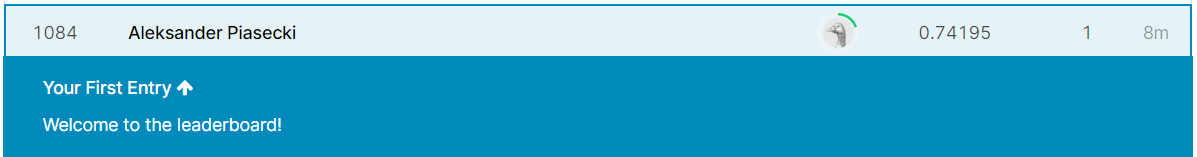

###Drugie podejście
Nowe kryterium - długość tweeta. Nowe kategorie słów - liczbowe i z nawiasem. Kategorie zliczane są jednokrotnie dla każdego słowa (np. link spełniający dwie konstrukcje). Za słowa linki uznawane są również te zawierające "www." oraz ".com".<br>
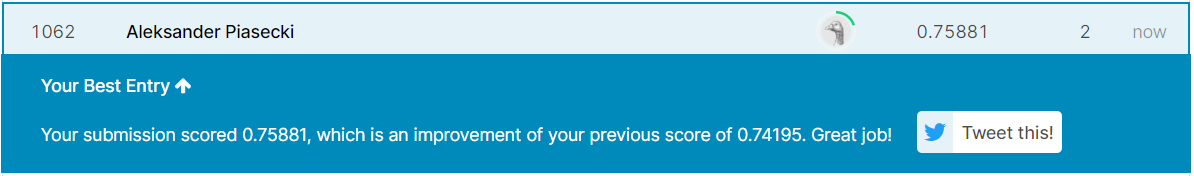<br>

###Trzecie podejście
Kryteria liczb i nawiasu usunięte. Wynik pozostał na podobnym poziomie.
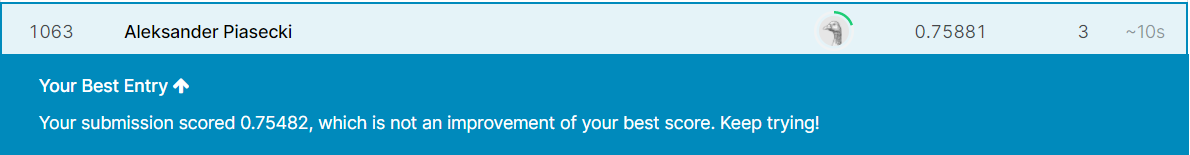

###Czwarte podejście
Lokalizacja została uwzględniona - oznaczanie błędnych nazw (z niewłaściwymi znakami) i miejsc pustych.<br>
Waga słów przydzielana w pełnym zakresie (oddzielne referencje) dla katastrof i fałszywych alarmów.
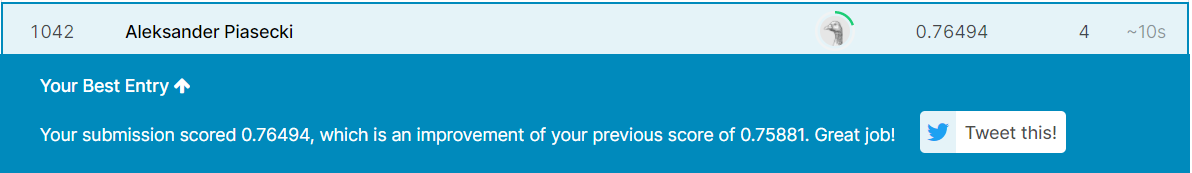

###Skuteczność
Pierwszy model osiągnął 74,2% trafności. Zostało to poprawione przy drugiej próbie (75,9%) oraz w kolejnych podejściach, uzyskując najlepszy wynik 76,5% dokładności.

###Wnioski
Nawet dane o stosunkowo niewielkiej decyzyjności (np. obecność hashtagów) poprawiają w pewnym stopniu wynik końcowy.<br>
Przydzielanie wag pogarsza dokładność, jednak znacznie zmniejsza rozmiar danych - słów kluczowych jest bardzo wiele nie stosując indeksowania konieczne byłoby utworzenie ponad 150 kolumn danych (dla każdego wiersza).<br>
W ogólnym przypadku zazwyczaj lepiej zapewnić dostęp do danych modelowi, niż je przetwarzać "samodzielnie" (np. usuwając małe współczynniki lub dokonując zaokrągleń). Kategorie zbędnie dodane nie pogorszyły wyniku (pozostał na podobnym poziomie).<br>
Przewidywania zapewne poprawiłoby pogrupowanie słów (podobnie, jak zostało zrealizowane z wyrażeniami kluczowymi). W tym przypadku zadanie to jest jendak trudniejsze:
* Podział słów z liczby mnogiej i pojedynczej (oraz końcówki "-ing", "-ed", "-es"), np. "risk" i "risks" zmniejsza ich wagę, ponieważ ta odniesiona jest do arbitralnej wartości (czyli im więcej słów, tym większa waga, ponieważ wyraz częściej pojawia się w tematyce katastrof).
* Proste oddzielenie końcówki poprowadziłoby do połączeń niepożądanych, np. "I" - "is", "a" - "as", "hi" - "his".
* Można byłoby wprowadzić analizę przydzieleń i łączyć jedynie słowa o tym samym ukierunkowaniu (tj. wskazywaniu katastrofy lub nie).
* Należałoby wówczas utworzyć listę zabronionych połączeń przy tłumaczeniu tekstu na liczbę lub łączyć słowa o największym dopasowaniu. Problem: "I" in "is" jest prawdą, jednak "is" in "is" daję większe podobieństwo.
* Bez dodatkowych ograniczeń nowy wyraz, np. "intermediate" mógłby zostać połączony z np. "media" (największe dopasowanie), choć najczęściej problem dotyczyłby zawierania krótkich konstrukcji (lub nawet pojedynczych liter) typu "I", "is", "at", itp.